<a href="https://colab.research.google.com/github/garciasergio94y/RNN/blob/LSTM_onehot_samples/LSTM_onehot_samples_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# Instalación y carga de librerías:

packages <- c("readxl", "purrr", "dplyr", "filesstrings",
              "stringr", "tidyr", "lubridate", "ggplot2",
              "tictoc", "wavelets", "reticulate", "abind",
              "tensorflow", "tfdatasets", "keras")

# Función para instalar paquetes si no están ya instalados
install_packages <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    }
}

# Aplicar la función para cada uno de los paquetes
lapply(packages, install_packages)

devtools::install_github('henry090/tfaddons')
tfaddons::install_tfaddons()

require(readxl)
require(purrr)
require(dplyr)
require(filesstrings)
require(stringr)
require(tidyr)
require(lubridate)
require(ggplot2)
#require(caret)
require(wavelets)
require(tictoc)
require(reticulate)
require(abind)
require(tensorflow)
require(tfaddons)
require(tfdatasets)
require(keras)


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

Skipping install of 'tfaddons' from a github remote, the SHA1 (640e4c26) has not changed since last install.
  Use `force = TRUE` to force installation



In [93]:
workingdir <- getwd()
datadir <- file.path(workingdir, "Datos/daily_s")
eventdir <- file.path(workingdir, "Datos/daily_s/Event")
eventdir_old <- file.path(workingdir, "Datos/daily_s/Event/old")
lotdir <- file.path(workingdir, "Datos/daily_s/Lot")
lotdir_old <- file.path(workingdir, "Datos/daily_s/Lot/old")
qcdir <- file.path(workingdir, "Datos/daily_s/qc")
qcdir_old <- file.path(workingdir, "Datos/daily_s/qc/old")
resultsdir <- file.path(workingdir, "Resultados")
figuresdir <- file.path(workingdir, "Resultados/Figuras")

In [ ]:
tensorflow::tf_gpu_configured()

TensorFlow built with CUDA:  TRUE 
GPU device name:  /device:GPU:0

[1] TRUE

Lectura de archivos de datos

In [3]:
# Leer archivo dataset desde Github:
url <- "https://raw.githubusercontent.com/garciasergio94y/RNN/LSTM_onehot_samples/Resultados/data_sel_tr?token=GHSAT0AAAAAACDRPTVSVKYJHB2QUS7LBN6KZEELRQQ"
data_sel_tr <- read.csv(url)

# Guardar una copia local:
# write.csv(data_sel_tr, file = "data_sel_tr", row.names = F, col.names = F) 


In [94]:
# Convertir fechas en formato POSIXct:
data_sel_tr[,1] %<>% as.POSIXct(tz = "Europe/Madrid")
head(data_sel_tr)

,TIEMPO_MUESTRA,RESULTADO,W1,W2,W3,W4,W5,W6,W7,W8,⋯,V5,V6,V7,V8,PACIENTE_SEXO,EDAD_BIN,ANALIZADOR,CODIGO_PRUEBA,NOMBRE_PRUEBA.x,CTRL
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,2022-02-28 23:20:02,4.200,-3.5615786,7.256192,-1.48703841,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
2,2022-02-28 22:02:47,9.800,2.2805652,1.332555,-1.43465727,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,F,Anciano,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
3,2022-02-28 22:35:48,4.300,7.0986609,-4.108060,-1.39786129,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,M,Adulto,DXI800 num 2,CLC00544,Creatina quinasa MB (masa),0
4,2022-02-28 20:53:57,0.042,0.8285582,-1.567219,-0.09554851,-12.806090,-3.136542,-3.8431761,0.1227499,NA,⋯,3.779275,2.740326,1.801031,NA,M,Anciano,DXI800 num 2,CLC00638,Procalcitonina,0
5,2022-02-28 08:35:20,7.100,11.7137247,4.220284,-1.88029062,-8.558415,-3.931813,-0.8030452,NA,NA,⋯,28.145486,25.473809,NA,NA,M,Adulto,DXI800 num 1,CLC00807,Vitamina D (25 OH),0
6,2022-02-28 14:19:26,237.000,118.5453826,-7.087632,81.99015157,74.434099,-5.675594,13.3709939,NA,NA,⋯,349.937302,315.608966,NA,NA,F,Anciano,DXI800 num 1,CLC00805,Vitamina B12,0


# Definición de funciones para transformación de variables, normalización y secuenciación de series de datos:


## Función ```sub_sample```

Realiza un submuestreo estratificado aleatorio de la clase mayoritaria CTRL = 0, sustituyendo las entradas de esta clase por las seleccionadas aleatoriamente después de agrupar por fecha y código de prueba.


In [23]:
sub_sample <- function(ds, prop){
  ss0 <- ds %>%
  mutate(FECHAS = as.Date(TIEMPO_MUESTRA)) %>%
  group_by(FECHAS, CODIGO_PRUEBA, CTRL) %>%
  filter(CTRL == 0) %>%
  slice_sample(prop = prop) %>%
  ungroup() %>%
  select(-FECHAS)
  
  ds_ss <- rbind(ds %>% filter(CTRL == 1), ss0)
  ds_ss %<>% arrange(TIEMPO_MUESTRA)
  
  return(ds_ss)
}

## Función ```normalize_train```.

Para la normalización de las variables continuas del dataset de entrenamiento y sustitución de valores NA en los coeficientes wavelet por un valor numérico arbitrario fácilmente enmascarable. Devuelve también una lista de vectores de medias y de desviaciones estándar que luego se usan como argumentos en para las funciones de normalización de los datasets de validación y test. De esta forma, el escalado y normalización se realiza con la misma media y desviación del set de entrenamiento para los otros dos datasets.

In [5]:
normalize_train <- function(data) {
   
  # Identificar las columnas que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  
  # Calcular medias y desviaciones estándar por grupos de pruebas y   analizador:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T))) 
  
  std_devs <- data %>% 
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
  
  # Normalizar las columnas de resultado y coeficientes wavelet
  norm_data <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    mutate(across(c(result_col, wavelet_cols), scale))%>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .))) %>%
    ungroup()
  
  # Devolver el dataframe escalado y las medias y desviaciones estándar:
  
  return(list(scaled_data = as.data.frame(norm_data), 
              means = means, stdev = std_devs))
}

## Función ```norm_test_val```.

Análoga a ```normalize_train```, pero con la diferencia de que usa la media y desviación estándar del dataset de entrenamiento para validar los datasets de validación y test:

In [6]:
norm_test_val <- function(data, means, stds) {
  
  # Identificar las columnas numéricas y seleccionarlas
  wavelet_cols <- grep("^[WV]", colnames(data), value = TRUE)
  result_col <- c("RESULTADO")
  test_cols <- "CODIGO_PRUEBA"
  cols <- c(result_col, wavelet_cols, test_cols)
  
  # Seleccionar medias y desviaciones de resultados y coeficientes   wavelet:
  means_r <- train_n$means
  stds_r <- train_n$stdev
  means_wl <- train_n$means[wavelet_cols]
  stds_wl <- train_n$stdev[wavelet_cols]
  
  # Normalizar por cada prueba las columnas de resultado y coeficientes wavelet usando las medias y desviaciones estándar de train suministradas:
  means <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
    left_join(means_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"), 
              suffix = c(".val", ".means")) %>%
     ungroup()
   
  stds <- data %>%
    group_by(ANALIZADOR, CODIGO_PRUEBA) %>%
     left_join(stds_r, by = c("ANALIZADOR", "CODIGO_PRUEBA"),
               suffix = c(".val", ".sd")) %>%
    ungroup()
     
    
  norm_data <- data %>%
    mutate(., RESULTADO.st =
             (.[,result_col]-
                select(means,
                       starts_with(result_col) &
                       ends_with(".means"))) /
                select(stds,
                       starts_with(result_col) &
                       ends_with(".sd"))
           ) %>%
    mutate(WAVELETS.st =
             across(all_of(wavelet_cols),
                    ~ (. - select(means, 
                                  starts_with(cur_column()) &
                                    ends_with(".means"))[[1]]) /
                      select(stds,
                             starts_with(cur_column()) &
                               ends_with(".sd"))[[1]])
           ) %>%
    select(-c(result_col, wavelet_cols)) %>%
    unnest(c(WAVELETS.st, RESULTADO.st)) %>%
    relocate(starts_with("RESULTADO"), .after = 1) %>%
    relocate(starts_with("W"), .after = 2) %>%
    relocate(starts_with("V"), .before = PACIENTE_SEXO) %>%
    mutate(across(wavelet_cols,
                           ~ifelse(is.na(.), -99999, .)))
    
  names(norm_data)[2]<-result_col
  
  return(as.data.frame(norm_data))
}

## Función ```code_cat_var```.

Convierte las variables categóricas tipo string en vectores numéricos y realiza una codificción one-hot, creando una lista que retiene en un vector la información de los niveles de los factores. 

In [14]:
code_cat_var <- function(data) {
  # Eliminación de la columna CODIGO_PRUEBA si solo tiene una          categoría:
  if(length(unique(data$CODIGO_PRUEBA))==1){
    data %<>% select(., -CODIGO_PRUEBA)
    }
  
  # Eliminación de los casos con sexo y/o indeterminadoz, debido a que son   muy minoritarios y crean una variable desequilibrada entre datasets:
  
  data %<>% filter(PACIENTE_SEXO != "U", EDAD_BIN != "Desconocido")
  
  # Detección de strings:
  cat_vars <- which(sapply(data, is.character))
  # Conversión a factores:
  data_cat <- lapply(data[,cat_vars], as.factor)
  # Extracción de niveles:
  levels <- lapply(data_cat, levels)
  
  # Codificar one-hot todas las variables factor:
  encoded_cols <- lapply(seq_along(data_cat), function(i) {
    cols <- model.matrix(~ factor(data_cat[[i]]) - 1)
    colnames(cols) <- paste0(names(data)[cat_vars[i]], "_",
                             levels[[i]])
    cols
    })
  
  # Unir columnas codificadas con conjunto de datos original:
  if (!"CODIGO_PRUEBA" %in% names(data)) {
    data_encoded <- bind_cols(data %>% 
                                select(-all_of(cat_vars)),
                                encoded_cols)
    } else {
      data_encoded <-  bind_cols(data %>%
                                   select(c(-all_of(cat_vars),
                                            -"CODIGO_PRUEBA")),
                                 encoded_cols)
      }
  
    # Reordenar columnas:
  data_encoded <- data_encoded %>%
  relocate(CTRL, .after = everything())
  
  return(list(data = data_encoded, levels = levels))
}


## Función ```unique_lab_cases```.

Crea un índice de casos únicos de combinaciones de variables categóricas.

In [8]:
  unique_lab_cases <- function(df, categorical_vars) {
  unique_groups <- unique(df[categorical_vars])
  
  code <- apply(unique_groups, 1, function(row) {
    paste0(ifelse(row == 1, 1, 0), collapse = "")
  })
  unique_groups %<>% mutate(., code)
  coded_df <- df %>%
    merge(unique_groups, ., by = colnames(unique_groups)
          [-length(colnames(unique_groups))])
  coded_df <- coded_df[, c(colnames(df), "code")]
  
  return(coded_df)
}

## Función ```create_lstm_data.1```.

Diseñada para la creación de lotes de series temporales de longitud k (lookback). Basada en la función presentada en Chollet François, Deep learning with Python. Shelter Island, NY: Manning Publications Co; 2018. 335 p. Cap. 6.3.2 

In [9]:
create_lstm_data.1 <- 
  function(data, lookback, delay, min_index, max_index,
           shuffle = FALSE, batch_size, step = 1,
           predseries) {
    
  if (is.null(max_index)) max_index <- nrow(data) - delay
  i <- min_index + lookback
  gen <- function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), 
                     size = batch_size)
    } else {
      if (i + batch_size > max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size-1, max_index))
      i <<- i + length(rows)
    }
    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]-1))
    targets <- array(0, dim = c(length(rows)))
    for (j in 1:length(rows)) {
      indices <- (rows[[j]] - lookback + 1):(rows[[j]])
      samples[j,,] <- data[indices, -predseries]
      targets[[j]] <- data[rows[[j]] + delay, predseries]
    }
    list(samples, targets)
  }
  return(gen)
}



## Funciones ```train_gen``` y ```val_gen```.

Funciones generadoras globales de series para train y validation, Estas funciones generan de manera indefinida series con los datos de entrenamiento y validación, usando de manera consecutiva las funciones generadoras individuales almacenadas junto a los subconjuntos de datos con las posibles combinaciones de variables categóricas. Si se llega a la generación última se repite el proceso desde la primera. Incluyen un TryCatch para evitar la parada del modelo si se encuentran secuencias de datos vacías.  

In [10]:
train_gen <- function() {
  indices <- sample(length(train_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      train_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}


val_gen <- function() {
  indices <- sample(length(val_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      val_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}

test_gen <- function() {
  indices <- sample(length(val_k))
  
  for (i in indices) {
    sequence <- tryCatch(
      test_k[[i]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (!is.null(sequence)) {
      return(sequence)
    }
  }
  
  NULL
}

# División de datasets:
Se divide el dataset en 50% de datos para entrenamiento, 25% para test y 25% para validación. Para evitar fraccionar las unidades temporales diarias usamos percentiles de la secuencia temporal en días: 

### División por percentiles de escala temporal


In [97]:

time_point_50 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(
  quantile(data_sel_tr[,1], 0.75)))

time_point_50
time_point_75

# Muestra de entrenamiento:
train <- data_sel_tr %>%
  subset(.[[1]] <= time_point_50)


# Muestra de validación:
val <- data_sel_tr %>%
  subset(
    .[[1]] > time_point_50 &
    .[[1]] <= time_point_75)
  

# Muestra de test:
test <- data_sel_tr %>%
  subset(.[[1]] > time_point_75)

             50% 
"2022-09-06 UTC" 

             75% 
"2022-12-20 UTC" 

## Normalización de los datasets

In [98]:
# Set de entrenamiento:
train_n <- train %>% normalize_train()

# Set de validación:
val_n <- val %>% norm_test_val(means = train_n$means,
                                  stds = train_n$stdev)
# Set de test:

test_n <- test %>% norm_test_val(means = train_n$means,
                                  stds = train_n$stdev)

`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'ANALIZADOR'. You can override using the
`.groups` argument.


### Downsampling estratificado por técnica.
Se emplea la función ```sub_sample``` diseñada para eliminar la proporción deseada de casos pertenecientes a la clase CTRL = 0 por muestreo
 estratificado aleatorio.

In [174]:
set.seed(123)

train_ss <- train_n$scaled_data %>% sub_sample(prop=0.5)

table(train_ss$NOMBRE_PRUEBA.x, train_ss$CTRL)

clc_dropout <- iqtests$CODIGO_PRUEBA[which(!(iqtests$CODIGO_PRUEBA %in%
               unique(train_ss$CODIGO_PRUEBA)))]

                                  
                                      0    1
  Ac anti peroxidasa tiroidea #TPO  400   68
  Ac anti tiroglobulina              21    0
  Ácido fólico                      557   12
  Alfa-Fetoproteína                 317    5
  Antígeno carcinoembrionario #CEA  544   44
  CA 125                            406   35
  CA 15.3                           410   29
  CA 19.9                           459   21
  Coriogonadotropina (beta total)    41    4
  Cortisol                           33    0
  Creatina quinasa MB (masa)         79   18
  Estradiol                         248   14
  Folitropina #FSH                  343   42
  Lutropina #LH                     342   31
  Paratirina (intacta) #PTHI        419   12
  Procalcitonina                   1791   70
  Progesterona                      285   17
  Prolactina                        419   34
  PSA                               403    8
  PSA (libre)                       248   26
  Testosterona      

In [175]:
# Pruebas incluídas en los datos:
  iqtests <- unique(data.frame(data_sel_tr$NOMBRE_PRUEBA.x,
                               data_sel_tr$CODIGO_PRUEBA))
  
  # Corrección de caracteres incorrectos en NOMBRE_PRUEBA:
  iqtests$data_sel_tr.NOMBRE_PRUEBA.x <- 
    iconv(iqtests$data_sel_tr.NOMBRE_PRUEBA.x, to = "UTF-8")
  iqtests <- iqtests[complete.cases(iqtests),]
  names(iqtests) <- c("NOMBRE_PRUEBA", "CODIGO_PRUEBA")

  # Sustitución en data de los nombres de prueba incorrectos:
  data_sel_tr$NOMBRE_PRUEBA.x <-
    iqtests$NOMBRE_PRUEBA[match(data_sel_tr$CODIGO_PRUEBA,
                                iqtests$CODIGO_PRUEBA)]




## Downsampling de casos con CTRL=0 en el training set.

set.seed(123)

train_ss <- train_n$scaled_data %>% sub_sample(prop=0.50)

table(train_ss$NOMBRE_PRUEBA.x, train_ss$CTRL)

clc_dropout <- iqtests$CODIGO_PRUEBA[which(!(iqtests$CODIGO_PRUEBA %in%
               unique(train_ss$CODIGO_PRUEBA)))]



                                  
                                      0    1
  Ac anti peroxidasa tiroidea #TPO  400   68
  Ac anti tiroglobulina              21    0
  Ácido fólico                      557   12
  Alfa-Fetoproteína                 317    5
  Antígeno carcinoembrionario #CEA  544   44
  CA 125                            406   35
  CA 15.3                           410   29
  CA 19.9                           459   21
  Coriogonadotropina (beta total)    41    4
  Cortisol                           33    0
  Creatina quinasa MB (masa)         79   18
  Estradiol                         248   14
  Folitropina #FSH                  343   42
  Lutropina #LH                     342   31
  Paratirina (intacta) #PTHI        419   12
  Procalcitonina                   1791   70
  Progesterona                      285   17
  Prolactina                        419   34
  PSA                               403    8
  PSA (libre)                       248   26
  Testosterona      

In [176]:
# Filtrado por código de pruebas que en training no tienen representación en la categoría CTRL = 1, y creación de una lista.

clc_sel <- list()

clc_sel[[1]] <- train_ss %>%
  group_by(CODIGO_PRUEBA) %>%
  filter(all(CTRL != 1) | all(CTRL != 0))

# Unión de los elementos de la lista y extracción de los CODIGO_PRUEBA que las componen:
clc_sel %<>% do.call(rbind, .)
clc_other <- c(clc_dropout, unique(clc_sel$CODIGO_PRUEBA))
names_other <- iqtests$NOMBRE_PRUEBA[iqtests$CODIGO_PRUEBA %in%
                                       clc_other]

# Subsetting de los dataframes de train, validation y test eliminando las entradas correspondientes a las pruebas encontradas en el paso anterior:
train_sel <- train_ss %>% subset(., !(CODIGO_PRUEBA %in% clc_other))
val_sel <- val_n %>% subset(., !(CODIGO_PRUEBA %in% clc_other))
test_sel <- test_n %>% subset(., !(CODIGO_PRUEBA %in% clc_other))

# Distribución tras la eliminación de estas pruebas

table(train_sel$NOMBRE_PRUEBA.x, train_sel$CTRL)
table(val_sel$NOMBRE_PRUEBA.x, val_sel$CTRL)
table(test_sel$NOMBRE_PRUEBA.x, test_sel$CTRL)

cat("Técnicas que no pueden entrenarse con estos datasets: ", names_other)

                                  
                                      0    1
  Ac anti peroxidasa tiroidea #TPO  400   68
  Ácido fólico                      557   12
  Alfa-Fetoproteína                 317    5
  Antígeno carcinoembrionario #CEA  544   44
  CA 125                            406   35
  CA 15.3                           410   29
  CA 19.9                           459   21
  Coriogonadotropina (beta total)    41    4
  Creatina quinasa MB (masa)         79   18
  Estradiol                         248   14
  Folitropina #FSH                  343   42
  Lutropina #LH                     342   31
  Paratirina (intacta) #PTHI        419   12
  Procalcitonina                   1791   70
  Progesterona                      285   17
  Prolactina                        419   34
  PSA                               403    8
  PSA (libre)                       248   26
  Testosterona                      347    6
  Tirotropina #TSH                 2260  315
  Tiroxina (libre) #

                                  
                                      0    1
  Ac anti peroxidasa tiroidea #TPO  417    5
  Ácido fólico                      577   10
  Alfa-Fetoproteína                 348    0
  Antígeno carcinoembrionario #CEA  564   32
  CA 125                            413   21
  CA 15.3                           379   29
  CA 19.9                           406    7
  Coriogonadotropina (beta total)    41    0
  Creatina quinasa MB (masa)        138   20
  Estradiol                         288    6
  Folitropina #FSH                  393   24
  Lutropina #LH                     427   12
  Paratirina (intacta) #PTHI        479    0
  Procalcitonina                   1905   36
  Progesterona                      325   41
  Prolactina                        384   30
  PSA                               435    3
  PSA (libre)                       300    2
  Testosterona                      363    0
  Tirotropina #TSH                 2234  100
  Tiroxina (libre) #

                                  
                                      0    1
  Ac anti peroxidasa tiroidea #TPO  377    7
  Ácido fólico                      623   43
  Alfa-Fetoproteína                 325   10
  Antígeno carcinoembrionario #CEA  487   17
  CA 125                            278   13
  CA 15.3                           322   33
  CA 19.9                           340    0
  Coriogonadotropina (beta total)    47    6
  Creatina quinasa MB (masa)        103    9
  Estradiol                         268    0
  Folitropina #FSH                  353   26
  Lutropina #LH                     340   26
  Paratirina (intacta) #PTHI        545    0
  Procalcitonina                   1701   28
  Progesterona                      297   19
  Prolactina                        367   37
  PSA                               411   41
  PSA (libre)                       245   17
  Testosterona                      301    0
  Tirotropina #TSH                 2280  425
  Tiroxina (libre) #

Técnicas que no pueden entrenarse con estos datasets:  Ac anti tiroglobulina Cortisol

## Codificación de variables mediante one-hot.

### Sin wavelets

In [177]:
train_code <- code_cat_var(subset(train_sel,
                                  select = -c(3:18, NOMBRE_PRUEBA.x)))

val_code <- code_cat_var(subset(val_sel,
                                  select = -c(3:18, NOMBRE_PRUEBA.x)))

test_code <- code_cat_var(subset(test_sel,
                                  select = -c(3:18, NOMBRE_PRUEBA.x)))

head(train_code$data)

,TIEMPO_MUESTRA,RESULTADO,PACIENTE_SEXO_F,PACIENTE_SEXO_M,EDAD_BIN_Adulto,EDAD_BIN_Anciano,EDAD_BIN_Joven,EDAD_BIN_Niño,ANALIZADOR_DXI800 num 1,ANALIZADOR_DXI800 num 2,⋯,CODIGO_PRUEBA_CLC11007,CODIGO_PRUEBA_CLC11015,CODIGO_PRUEBA_CLC11768,CODIGO_PRUEBA_CLC11775,CODIGO_PRUEBA_CLC11797,CODIGO_PRUEBA_CLC11816,CODIGO_PRUEBA_CLC11837,CODIGO_PRUEBA_CLC11846,CODIGO_PRUEBA_CLC11854,CTRL
,<dttm>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2022-02-28 00:21:32,2.8723699,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2022-02-28 05:00:41,-0.1453159,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
3,2022-02-28 07:27:14,-0.0785065,0,1,1,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
4,2022-02-28 09:04:27,-0.1391580,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
5,2022-02-28 09:17:56,-0.1539202,0,1,1,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
6,2022-02-28 12:15:32,0.1115946,1,0,0,0,1,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


### Con wavelets

In [57]:
train_code <- code_cat_var(subset(train_sel,
                                  select = -NOMBRE_PRUEBA.x))

val_code <- code_cat_var(subset(val_sel,
                                  select = -NOMBRE_PRUEBA.x))

test_code <- code_cat_var(subset(test_sel,
                                  select = -NOMBRE_PRUEBA.x))

head(train_code$data)

,TIEMPO_MUESTRA,RESULTADO,W1,W2,W3,W4,W5,W6,W7,W8,⋯,CODIGO_PRUEBA_CLC11007,CODIGO_PRUEBA_CLC11015,CODIGO_PRUEBA_CLC11768,CODIGO_PRUEBA_CLC11775,CODIGO_PRUEBA_CLC11797,CODIGO_PRUEBA_CLC11816,CODIGO_PRUEBA_CLC11837,CODIGO_PRUEBA_CLC11846,CODIGO_PRUEBA_CLC11854,CTRL
,<dttm>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2022-02-28 00:21:32,2.8723699,-0.002771341,0.107174599,0.002853283,0.031044265,-0.32112735,-0.16324420,4.079377e-02,-99999,⋯,0,0,0,0,0,0,0,0,0,0
2,2022-02-28 05:00:41,-0.1453159,0.159908491,0.004134627,-0.032454303,0.010211938,-0.23620441,-0.23086449,3.217151e-01,-99999,⋯,0,0,0,0,0,0,0,0,0,0
3,2022-02-28 07:27:14,-0.0785065,0.006672282,1.472640419,-0.016109558,0.007517284,-0.14808031,-0.01426478,-2.032753e-01,-99999,⋯,0,0,0,0,0,0,0,0,0,0
4,2022-02-28 09:04:27,-0.1391580,-0.002072266,1.196861448,-0.018758348,0.006328446,-0.05080433,0.05035498,-2.745915e-01,-99999,⋯,0,0,0,0,0,0,0,0,0,0
5,2022-02-28 09:17:56,-0.1539202,-0.027033273,-0.029946839,0.028959525,0.021382739,-0.29146218,-0.21889726,2.243953e-01,-99999,⋯,0,0,0,0,0,0,0,0,0,0
6,2022-02-28 12:15:32,0.1115946,-0.783940788,0.774370572,0.999042602,1.826255314,-0.28695508,0.50522373,-9.999900e+04,-99999,⋯,0,0,0,0,0,0,0,0,0,0


## Preparación de series temporales de longitud k agrupadas por categorías en los datasets de training y validación. 

In [178]:
names(train_code$data)
length(train_code$data)


[1] "TIEMPO_MUESTRA"          "RESULTADO"              
 [3] "PACIENTE_SEXO_F"         "PACIENTE_SEXO_M"        
 [5] "EDAD_BIN_Adulto"         "EDAD_BIN_Anciano"       
 [7] "EDAD_BIN_Joven"          "EDAD_BIN_Niño"          
 [9] "ANALIZADOR_DXI800 num 1" "ANALIZADOR_DXI800 num 2"
[11] "CODIGO_PRUEBA_CLC00033"  "CODIGO_PRUEBA_CLC00034" 
[13] "CODIGO_PRUEBA_CLC00061"  "CODIGO_PRUEBA_CLC00544" 
[15] "CODIGO_PRUEBA_CLC00638"  "CODIGO_PRUEBA_CLC00805" 
[17] "CODIGO_PRUEBA_CLC00807"  "CODIGO_PRUEBA_CLC00811" 
[19] "CODIGO_PRUEBA_CLC00813"  "CODIGO_PRUEBA_CLC00814" 
[21] "CODIGO_PRUEBA_CLC00815"  "CODIGO_PRUEBA_CLC00816" 
[23] "CODIGO_PRUEBA_CLC00817"  "CODIGO_PRUEBA_CLC00820" 
[25] "CODIGO_PRUEBA_CLC00821"  "CODIGO_PRUEBA_CLC02816" 
[27] "CODIGO_PRUEBA_CLC11007"  "CODIGO_PRUEBA_CLC11015" 
[29] "CODIGO_PRUEBA_CLC11768"  "CODIGO_PRUEBA_CLC11775" 
[31] "CODIGO_PRUEBA_CLC11797"  "CODIGO_PRUEBA_CLC11816" 
[33] "CODIGO_PRUEBA_CLC11837"  "CODIGO_PRUEBA_CLC11846" 
[35] "CODIGO_PRUEBA_CLC11854"  "CTRL"

[1] 36

In [179]:
# Creación de los códigos identificativos únicos de combinaciones de variables categóricas para el set de training usando la función unique_lab_cases e indicando las posiciones de las variables categóricas en train_code$data que se deseen incluir (en este caso el analizador): 

# categorical_vars <- c(12:38) # Todas las técnicas, 
                             #sin analizador ni wavelets
#categorical_vars <- c(10:38) # Todas las técnicas y analizadores
                             # sin wavelets
categorical_vars <- seq(11,length(train_code$data)-1) # Técnicas seleccionadas, 
                              # sin analizador ni wavelets
 
#categorical_vars <- c(39) # Clasificación según variable respuesta, sin                              wavelets
# categorical_vars <- c(57) # Clasificación según variable respuesta, con                              wavelet

train_indx <- unique_lab_cases(train_code$data,
                               categorical_vars)

# Extraemos los códigos para realizar un diccionario de traducción de códigos únicos a índices numéricos:
code_values <- unique(train_indx[,"code"])
code_dictionary <- data.frame(code = code_values)
code_dictionary %<>%  
  mutate(., index = as.numeric(factor(code_values, 
                                      levels = code_values)))

# Sustituimos los códigos de train_indx por sus índices numéricos:
train_indx$index <- code_dictionary$index[match(train_indx$code, code_dictionary$code)]
unique_indexes <- unique(train_indx$index)
train_indx$code <- NULL
train_indx %<>% arrange(., train_indx$TIEMPO_MUESTRA)

# Opción 1: generamos series de tiempo solo del día anterior al estado CTRL:
  # Creamos todas las posibles combinaciones de códigos y fechas:
#train_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_train <- expand.grid(index = unique_indexes,
                                  ctrl = 0:1)
                          #  date = unique(train_indx$TIEMPO_MUESTRA))


In [203]:
# Creación de lista de funciones generadoras de las series temporales de longitud k por categoría de CODIGO_PRUEBA del dataset de entrenamiento. Se generan series para cada día de observación conteniendo los resultados pertenecientes a cada una de las categorías elegidas:

# Hiperparámetros para generar las series temporales:
lookback <- 100 # Longitud de la secuencia previa al target.
delay <- 0 # Se escoge 0 debido a que los targets futuros ya se                 colocaron en la misma fila que la muestra del día                  anterior.
batch_size <- 100000 # Tamaño de batch.
min_index <- 1 # Indice de partida de la serie temporal.
predseries <- length(train_indx) - 2 # Posición en el dataset de la variable a predecir (CTRL) una vez eliminados TIEMPO_MUESTRA e index.

train_k <- mapply(function(index, ctrl) {#, date) {
  data <- as.matrix(
  train_indx[#train_indx[,"TIEMPO_MUESTRA"] == date &
             train_indx[,"CTRL"] == ctrl &  
             train_indx[,"index"] == index,
             - c(1, length(train_indx))])
  max_index <- nrow(data) - delay -1
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
},
index = combinations_train$index,
ctrl = combinations_train$ctrl,
#index = combinations_train$index,
#date = combinations_train$date,
SIMPLIFY = T
)

# Cálculo del número de steps de training:
train_steps <- length(train_k) # En cada step se generarán las series temporales correspondientes a cada índice.

In [204]:
# Creación de los índices identificativos de combinaciones de variables categóricas para el set de validación:
val_indx <- unique_lab_cases(val_code$data, 
                             categorical_vars)

# Usamos el diccionario de códigos creado anteriormente: 
val_indx$index <- code_dictionary$index[match(val_indx$code,
                                           code_dictionary$code)]
unique_indexes <- unique(train_indx$index)
val_indx$code <- NULL
val_indx %<>% arrange(., val_indx$TIEMPO_MUESTRA)

# Opción 1 para el dataset de validación:

# Generar todas las combinaciones de index y CTRL #date para el set de validación:

# val_indx$TIEMPO_MUESTRA %<>% as.Date()

combinations_val <- expand.grid(index = unique_indexes,
                                ctrl = 0:1)
                            #date = unique(val_indx$TIEMPO_MUESTRA))

In [205]:
# Creación de lista de funciones generadoras del dataset de validación:

val_k <- mapply(function(index, ctrl){#, date) {
  data <- as.matrix(
  val_indx[#val_indx[,"TIEMPO_MUESTRA"] == date &
              val_indx[,"CTRL"] == ctrl & 
              val_indx[,"index"] == index,
             - c(1, length(val_indx))])
  max_index <- nrow(data)-delay-1
  
  create_lstm_data.1(
    data = data,
    lookback = lookback,
    delay = delay,
    batch_size = batch_size,
    min_index = min_index,
    max_index = max_index,
    predseries = predseries)
  },
  index = combinations_val$index,
  ctrl = combinations_val$ctrl,
  #index = combinations_val$index,
  #date = combinations_val$date,
  SIMPLIFY = T
)  

# Cálculo del número de steps de validación:
val_steps <- length(val_k)

In [206]:
# Función para ajustar la probabilidad de muestrear secuencias según valor de la variable CTRL.

sampling_prob <- function(index, prob_red) {
  index_num <- length(index)
  half_point <- index_num / 2
  
  # Crear vector de probabilidades de muestreo
  sampling_prob <- rep(1, index_num)
  sampling_prob[1:half_point] <- prob_red
  
  # Normalizar probabilidades para que sumen 1
  sampling_prob <- sampling_prob / sum(sampling_prob)
  
  return(sampling_prob)
}

train_probs <- sampling_prob(combinations_train$index, 1)
val_probs <- sampling_prob(combinations_val$index, 1)

In [207]:
# Creamos un muestreo de índices con las probabilidades calculadas para dar más representación a las secuencias con CTRL=1:
indexes_train <- sample(length(train_k),
                        replace = T,
                        prob = train_probs)
# Iniciamos un contador externo a la función.
counter_train <- 1

#Definimos la función generadora global:
train_gen <- function() {
  if (counter_train > length(train_k)) {
    counter_train <<- 1
  } # Condición para resetear el contador si se llega a la última función generadora en train_k
  
  # Se selecciona el primer índice de los muestreados:
  index <- indexes_train[[counter_train]]
  # Se inicializa la variable que contendrá las secuencias:
  sequence <- NULL
  
  # Se inicializa un loop while en el que la condición para que se mantenga sería que no se generase ninguna secuencia mientras el contador llega a la última función generadora.
  
  while (is.null(sequence) && counter_train <= length(train_k)) {
    sequence <- tryCatch( #tryCatch captura los mensajes de error y                                devuelve una secuencia nula, que mantiene el                             loop while activo para buscar otra.
      train_k[[index]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)  # Devuelve NULL si ocurre un error en la                               función generadora
      }
    )
    
    if (counter_train == length(train_k) && is.null(sequence)) {
      counter_train <<- 1
      index <- indexes_train[counter_train]
      } else {
        if (is.null(sequence)){
          counter_train <<- counter_train + 1
          index <- indexes_train[counter_train]
        }
      }
    
    counter_train <<- counter_train + 1
    
  }
  
  return(sequence) 
  # En caso de encontrar una secuencia no nula se aumenta el contador una unidad y se devuelve la secuencia. Si la sencuencia es nula al llegar a la última generadora, se resetea el contador y se genera una secuencia con el nuevo contador en valor 1.
}

In [208]:
# Análoga a la anterior:

indexes_val <- sample(length(val_k),
                      replace = F,
                      prob = val_probs
                        )

counter_val <- 1

val_gen <- function() {
  if (counter_val > length(val_k)) {
    counter_val <<- 1
  } 
  
  index <- indexes_val[[counter_val]]
  
  sequence <- NULL
  
  while (is.null(sequence) && counter_val <= length(val_k)) {
    sequence <- tryCatch( 
      val_k[[index]](),
      error = function(e) {
        warning("Empty sequence error occurred in the generator.
                Trying the next one.")
        return(NULL)
      }
    )
    
    if (counter_val == length(val_k) && is.null(sequence)) {
      counter_val <<- 1
      index <- indexes_val[counter_val]
      } else {
        if (is.null(sequence)){
          counter_val <<- counter_val + 1
          index <- indexes_val[counter_val]
        }
      }
    
    counter_val <<- counter_val + 1
    
  }
  
  return(sequence) 
}

# Definición del modelo de Machine Learning. Red Neuronal Recurrente LSTM (Long-short term memory).

## Métricas


In [124]:
# Funciones para calcular precisión, recall y F1 como métricas para los modelos:
  
  K <- backend()

  precision <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Positivos predichos:
    predicted_positives <- sum(K$round(K$clip(y_pred, 0, 1)))
    
    # Precisión: 
    precision <- true_positives / (predicted_positives + K$epsilon())
    
  return(precision)
  }
  
  recall <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Recall:
    recall <- true_positives / (possible_positives + K$epsilon())
    
  return(recall)
}

  f1_score <- function(y_true, y_pred) {
    # Verdaderos positivos: 
    true_positives <- sum(K$round(K$clip(y_true * y_pred, 0, 1)))
    
    # Posibles positivos: 
    possible_positives <- sum(K$round(K$clip(y_true, 0, 1)))
    
    # Positivos predichos:
    predicted_positives <- sum(K$round(K$clip(y_pred, 0, 1)))
    
    # Precisión: 
    precision <- true_positives / (predicted_positives + K$epsilon())
    
    # Recall:
    recall <- true_positives / (possible_positives + K$epsilon())
    
    # F1 score:
    f1_score <- 2 * precision * recall / (precision + recall +
                                            K$epsilon())
  return(f1_score)
}

# Asignación de los nombres de las funciones como atributos py_function_name:

attr(f1_score, "py_function_name") <- "f1_score"
attr(precision, "py_function_name") <- "precision"
attr(recall, "py_function_name") <- "recall"

## Diseño del modelo

In [220]:
set.seed(123)
t <- train_gen()
nkp <- dim(t[[1]])

k <- nkp[2]
p <- nkp[3]

input_shape <- c(NULL, k, p)

model_1 <- keras_model_sequential() %>%
  
  #layer_masking(mask_value = -99999, input_shape = input_shape) %>%
  layer_lstm(units = 200,
             dropout = 0.8,
             recurrent_dropout = 0.8,
             return_sequences = T,
             #stateful = T,
             kernel_regularizer = regularizer_l2(l = 0.0001),
             #batch_size = 1,
             input_shape = c(NULL, k, p)) %>%
  layer_lstm(units = 200,
              dropout = 0.8,
              recurrent_dropout = 0.8,
              return_sequences = F,
              kernel_regularizer = regularizer_l2(l = 0.0001),
              input_shape = c(NULL, k, p)) %>%
  #layer_lstm(units = 32,
  #           dropout = 0.3,
  #           recurrent_dropout = 0,
  #           # kernel_regularizer = regularizer_l2(l = 0.001),
  #           return_sequences = F) %>%  
  layer_dense(units = 1, 
             # kernel_regularizer = regularizer_l2(l = 0.01),
             activation = "softmax")

summary(model_1)

Model: "sequential_13"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_19 (LSTM)                     (None, 100, 200)                188000      
 lstm_18 (LSTM)                     (None, 200)                     320800      
 dense_17 (Dense)                   (None, 1)                       201         
Total params: 509,001
Trainable params: 509,001
Non-trainable params: 0
________________________________________________________________________________


## Compilación y callbacks

In [221]:
model_1 %<>% compile(
  optimizer = optimizer_adam(learning_rate = 0.00001),
  #loss = "binary_crossentropy",
  loss = loss_sigmoid_focal_crossentropy(
    reduction = tf$keras$losses$Reduction$AUTO),
  metrics = list("binary_accuracy",
                 precision,
                 recall,
                 f1_score)
  )
   
callbacks <- list(
  callback_tensorboard(log_dir=file.path(resultsdir, "run_a"),
                       write_grads = T,
                       histogram_freq = 1,
                       update_freq = "batch",
                       write_images = T),
  callback_model_checkpoint(file.path(resultsdir, "lstm_1.keras",
                           monitor= "f1_score", mode="max",verbose=1,
                                     save_best_only = TRUE)),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.1,
                                patience = 3, min_lr = 0.000001),
  callback_early_stopping(monitor = "val_loss", patience = 10,
                          verbose = 1)
  )



## Entrenamiento

In [222]:
#tensorboard(file.path(resultsdir, "run_a"), port=8088)

# tensorboard dev upload --logdir ./

history_1 <- model_1 %>% fit_generator(
  generator = train_gen,
  steps_per_epoch = train_steps,
  epochs = 10,
  validation_data = val_gen,
  validation_steps = val_steps,
  callbacks = callbacks,
  view_metrics = T
)


Warning message in fit_generator(., generator = train_gen, steps_per_epoch = train_steps, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the gene

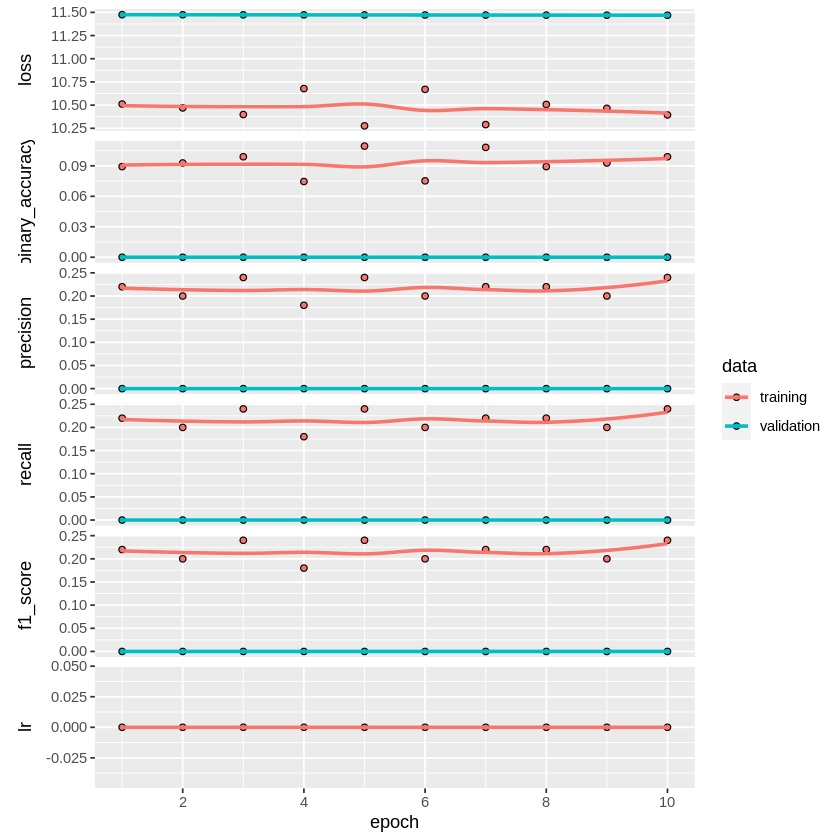

In [224]:
plot(history_1)

In [151]:
dim(train_gen()[[1]])

[1] 23 20 34

## Evaluación del modelo

In [ ]:
set.seed(123)

# Evaluación del modelo:
path <- file.path(resultsdir, "lstm_1.keras/TRUE")

model <- load_model_hdf5(path, 
                         custom_objects = 
                           list("f1_score" = f1_score,
                                "precision" = precision,
                                "recall" = recall),
                                 compile = T) 

evaluation_result <- evaluate(model, test_gen, steps = test_steps)

# Obtener el nombre de las métricas
metric_names <- names(evaluation_result)

# Crear un vector para almacenar los resultados
evaluation_results <- length(metric_names)

# Almacenar los resultados en el vector
for (i in 1:length(metric_names)) {
  evaluation_results[i] <- evaluation_result[[i]]
}


Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”
Warning message in value[[3L]](cond):
“Empty sequence error occurred in the generator.
                Trying the next one.”


## Cálculo de la línea base de sentido común:
Calcula la exactitud mínima del modelo, basada en la predicción de todos los casos con el target más frecuente

In [ ]:
# Función para calcular la exactitud mínima del modelo, basada en la predicción de todos los casos con el target más frecuente

evaluate_naive_method <- function(data_df, ctrl_colname) { 
  # Cálculo de la moda de CTRL:
  ctrl_mode <- as.numeric(names(sort(table(
    data_df[[ctrl_colname]]),
    decreasing = TRUE)[1]))

  # Cálculo de accuracy:
  actual_ctrl <- data_df[[ctrl_colname]]
  predicted_ctrl <- rep(ctrl_mode, length(actual_ctrl))
  accuracy <- sum(actual_ctrl == predicted_ctrl) /
    length(actual_ctrl)

  accuracy
}

# Cálculo de accuracy basado en predecir con la moda:
accuracy_train <- evaluate_naive_method(train_n$scaled_data, "CTRL")
accuracy_val <- evaluate_naive_method(val_n, "CTRL")
accuracy_test <- evaluate_naive_method(test_n, "CTRL")

# Comparación con rendimiento obtenido:

names(evaluation_results[3]) <- "f1_score"

# Imprimir los resultados de evaluación:

sink(file.path(resultsdir, "modelgc_1_LSTM_onehot_samples.txt"))

for (i in 1:length(metric_names)) {
  metric <- metric_names[i]
  value <- evaluation_results[i]
  cat(sprintf("%s: %f\n", metric, value))
}

sprintf("Training naive accuracy: %.2f", accuracy_train)
sprintf("Validation naive accuracy: %.2f", accuracy_val)
sprintf("Test naive accuracy: %.2f", accuracy_val)

# Cerrar el archivo de salida
sink()

loss: 0.000007
binary_accuracy: 1.000000
precision: 0.356322
recall: 0.356322
f1_score: 0.356322


[1] "Training naive accuracy: 0.94"

[1] "Validation naive accuracy: 0.93"

[1] "Test naive accuracy: 0.93"

## Evaluación por técnica

In [ ]:
# Función para seleccionar los índices en test_indx que corresponden a una combinación determinada de CODIGO_PRUEBA, Y ANALIZADOR. Usa el argumento n según la estructura de datos en función de si hay wavelets o no:

n <- 11 # Sin wavelets ni analizador

index_select <- function(n, clc) {
  
  # Conversión de las variables introducidas en índice:
  
  col_clc <- which(grepl(clc, names(test_indx)))-n
  #col_anal <- which(grepl(anal, names(test_indx)))-n
  pos <- list(col_clc)#, col_anal)
  
  code <- rep(0, length(categorical_vars+2))
  
  for (i in seq_along(pos)) {
    code[pos[[i]]] <- 1 
  }
  code <- paste0(as.character(code), collapse = "")
  
  index <- code_dictionary$index[match(code,
                                       code_dictionary$code)]
  print(index)
  return(index)
  
}
index_pred <- c(1, 2)
#index_pred <- index_select(n)

  test_pred <- lapply(index_pred, function(idx) {
    create_lstm_data.1(
      data = as.matrix(test_indx[test_indx[,"index"] == idx,
                                 -c(1, length(test_indx))]),
      lookback = lookback,
      delay = delay,
      batch_size = batch_size,
      min_index = min_index,
      max_index = 
      nrow(as.matrix(test_indx[test_indx[,"index"] == idx,]))-delay-1,
      predseries = predseries)
  }
  )


In [ ]:
# Obtener las series y sus predicciones utilizando la función generadora de tests por categorías y obtener la predicción del modelo:
x <- test_pred[[1]]()[[1]]
y_pred <- predict(model, x, probability = T)
y_true <- test_pred[[1]]()[[2]]

preds <- prediction(as.vector(y_pred), as.vector(y_true))
perf <- performance(preds, "tpr","fpr")

roc(as.vector(y_true), as.vector(y_pred), plot = TRUE, 
    legacy.axes = TRUE,
    percent = TRUE, xlab = "Porcentaje Falsos positivos",
    ylab = "Porcentaje verdaderos postivios", col = "#377eb8", lwd = 2,
    print.auc = TRUE)

ERROR: ignored